Для разработки сервиса предсказания стоимости домов на основе истории предложений, нам потребуется выполнить несколько ключевых шагов, начиная с предварительной обработки данных и заканчивая построением и развертыванием модели машинного обучения. Рассмотрим поэтапно процесс разработки такого сервиса:

Первичный анализ данных (EDA):

    Сбор и загрузка данных.
    Анализ структуры данных, проверка наличия пропущенных значений и распределения значений в каждом столбце.
    Очистка данных от аномалий и обработка пропущенных значений.

Статистический анализ данных:

    Проверка корреляций между признаками.
    Применение статистических тестов для подтверждения гипотез.

Использование инструментов визуализации:

    Визуализация распределения целевой переменной и признаков.
    Построение графиков, таких как гистограммы, диаграммы размаха, матрица корреляций и др.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import json


# Загрузка датасета
df = pd.read_csv(r'C:\Users\user\OneDrive\jupyter\housedata.csv')

Анализ структуры данных, проверка наличия пропущенных значений и распределения значений в каждом столбце.

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: 

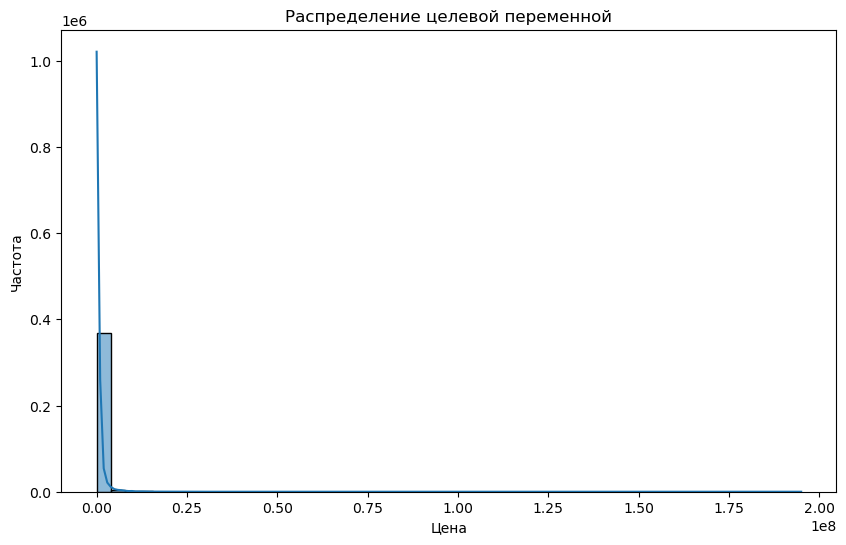

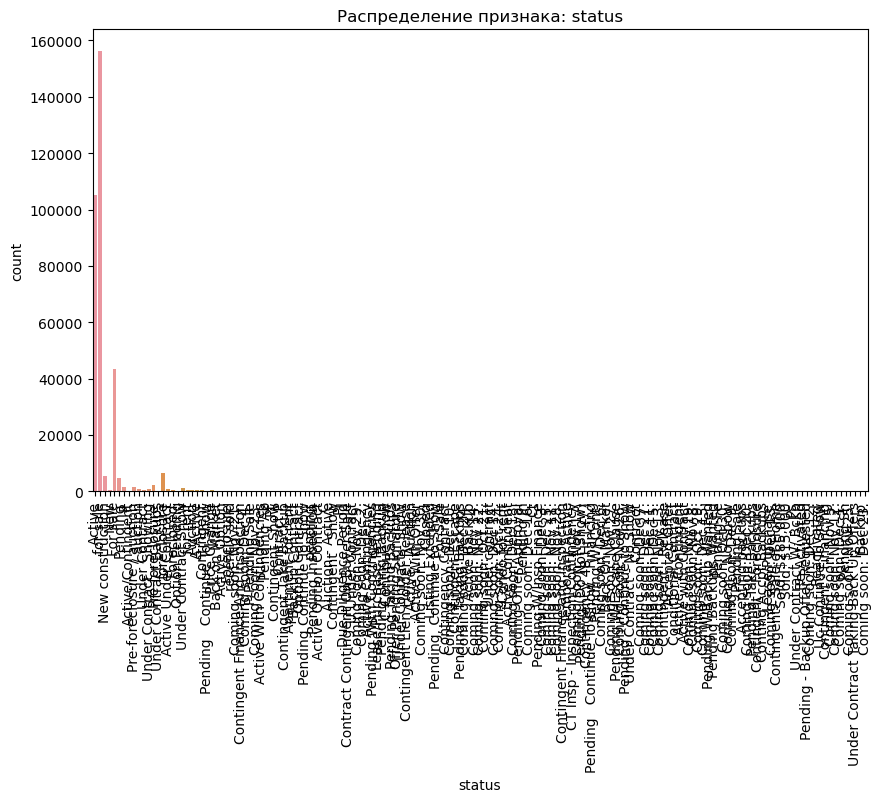

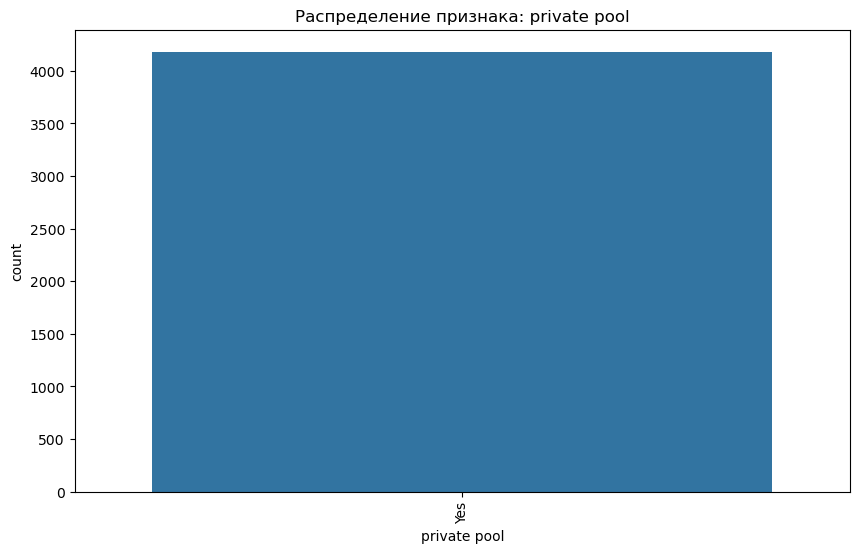

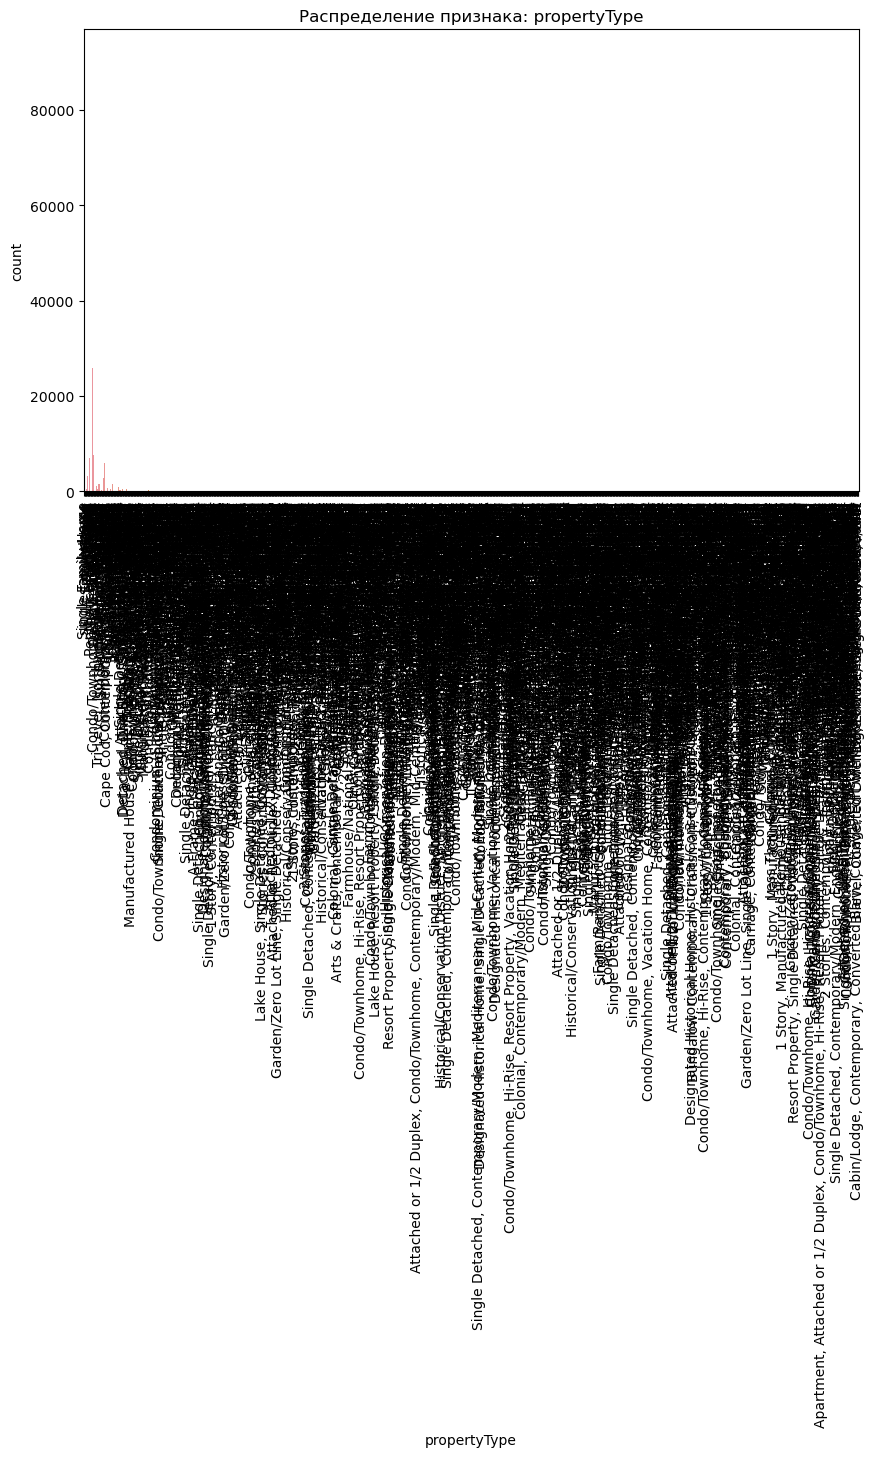


KeyboardInterrupt



<Figure size 1000x600 with 0 Axes>

In [2]:
# 1. Первичный анализ данных (EDA)

# Информация о данных
print("Информация о данных:")
print(df.info())

# Описание данных
print("\nОписание данных:")
print(df.describe(include='all'))

# Первые 5 строк данных
print("\nПервые 5 строк данных:")
print(df.head())

# Проверка на пропущенные значения
print("\nПропущенные значения в данных:")
print(df.isnull().sum())

# Очистка целевого столбца "target" от символов валюты и "/mo" и преобразование в числовой формат
df['target'] = df['target'].replace('[\$,]', '', regex=True)
df['target'] = df['target'].replace('[\+]', '', regex=True)
df['target'] = df['target'].replace('/mo', '', regex=True)
df['target'] = pd.to_numeric(df['target'], errors='coerce')

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(df['target'], bins=50, kde=True)
plt.title('Распределение целевой переменной')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

# Визуализация распределения признаков
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Распределение признака: {col}')
    plt.xticks(rotation=90)
    plt.show()

# 2. Очистка данных от аномалий и обработка пропущенных значений

# Обработка пропущенных значений в целевом столбце медианой
imputer = SimpleImputer(strategy='median')
df['target'] = imputer.fit_transform(df[['target']])

# Обработка пропущенных значений в числовых столбцах
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols[num_cols != 'target']  # Исключаем целевую переменную
for col in num_cols:
    df[col] = imputer.fit_transform(df[[col]])

# Обработка пропущенных значений в категориальных столбцах
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 3. Статистический анализ данных и использование инструментов визуализации

# Корреляционный анализ
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.show()

# Проверка гипотез
fireplace_groups = df.groupby('fireplace')['target']
t_stat, p_val = stats.ttest_ind(fireplace_groups.get_group('yes'), fireplace_groups.get_group('no'), nan_policy='omit')
print(f"Результаты T-теста для наличия камина: t-stat={t_stat}, p-value={p_val}")

# Подготовка данных для модели
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'target']  # Исключаем целевую переменную

# Убедимся, что все столбцы присутствуют после предобработки
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Разделение данных на обучающую и тестовую выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание пайплайна
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features) if numerical_features else ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', RandomForestRegressor())])

# Обучение модели
model_pipeline.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}')

Дальнейшие шаги

    Очистка данных:
        Удаление символов валюты и преобразование целевой переменной target в числовой формат.
        Преобразование текстовых значений в столбцах baths, beds, stories, sqft в числовой формат.
        Заполнение пропущенных значений в числовых столбцах медианой, а в категориальных столбцах — модой.

    Преобразование сложных структур данных:
        Разбор и обработка JSON-строк в столбцах homeFacts и schools.

    Анализ и визуализация:
        Проведение корреляционного анализа.
        Применение статистических тестов для проверки гипотез.
        Визуализация распределения целевой переменной и признаков.

Очистка данных:
Удаление символов валюты и преобразование целевой переменной target в числовой формат

In [3]:
# Очистка целевого столбца "target" от символов валюты и "/mo" и преобразование в числовой формат
df['target'] = df['target'].replace('[\$,]', '', regex=True)
df['target'] = df['target'].replace('[\+]', '', regex=True)
df['target'] = df['target'].replace('/mo', '', regex=True)
df['target'] = pd.to_numeric(df['target'], errors='coerce')

Преобразование текстовых значений в столбцах baths, beds, stories, sqft в числовой формат

In [4]:
# Преобразование столбцов "baths", "beds", "stories", "sqft" в числовой формат
df['baths'] = df['baths'].str.extract('(\d+)').astype(float)
df['beds'] = df['beds'].str.extract('(\d+)').astype(float)
df['stories'] = df['stories'].str.extract('(\d+)').astype(float)
df['sqft'] = df['sqft'].str.replace(',', '').str.extract('(\d+)').astype(float)

Заполнение пропущенных значений в числовых столбцах медианой, а в категориальных столбцах — модой

In [5]:
from sklearn.impute import SimpleImputer

# Заполнение пропущенных значений в числовых столбцах медианой
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Заполнение пропущенных значений в категориальных столбцах модой
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

Преобразование сложных структур данных:
Разбор и обработка JSON-строк в столбцах homeFacts и schools

In [6]:
# Функция для проверки корректности JSON-строк
def is_valid_json(s):
    try:
        json.loads(s)
        return True
    except (ValueError, TypeError):
        return False

# Функция для разбора и обработки JSON-строк
def parse_json_column(df, column):
    valid_rows = df[column].apply(is_valid_json)
    parsed_data = pd.json_normalize(df[valid_rows][column].apply(json.loads))
    parsed_data.columns = [f"{column}_{subcolumn}" for subcolumn in parsed_data.columns]
    df = df.drop(columns=[column])
    return df.join(parsed_data, how='left')

# Применение функции к столбцам homeFacts и schools
df = parse_json_column(df, 'homeFacts')
df = parse_json_column(df, 'schools')

Анализ и визуализация:
Проведение корреляционного анализа

C:\Users\user\AppData\Local\Temp\ipykernel_13024\2239476242.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


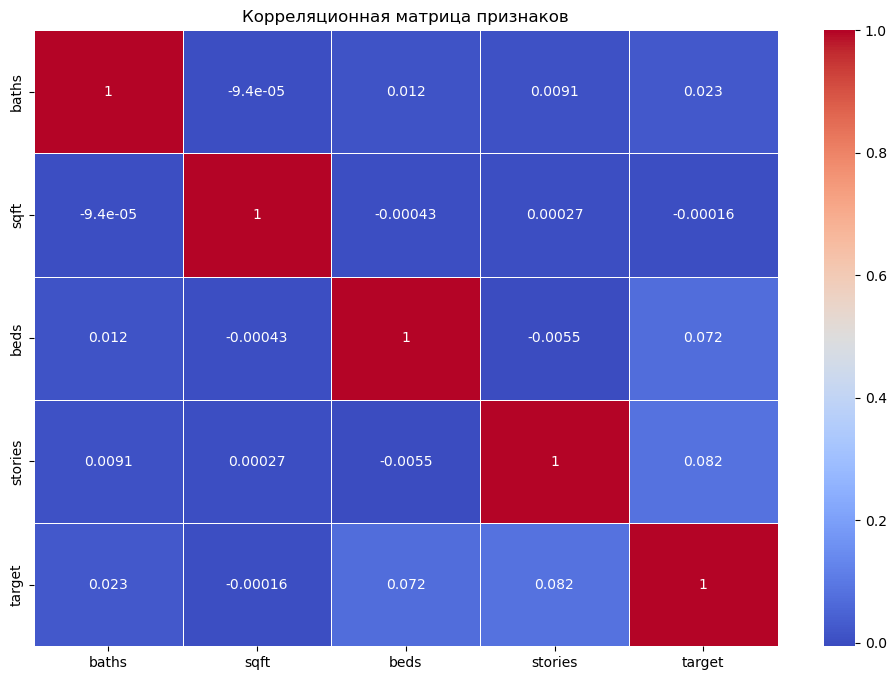

In [7]:
# Корреляционный анализ
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.show()

Применение статистических тестов для проверки гипотез

In [8]:
# Проверка уникальных значений в столбце fireplace
unique_fireplace_values = df['fireplace'].unique()
print("Уникальные значения в столбце fireplace:", unique_fireplace_values)

# Проверка гипотез: пример для наличия камина
fireplace_groups = df.groupby('fireplace')['target']

# Посмотрим на ключи группировки
print("Ключи группировки:", fireplace_groups.groups.keys())

# Выполнение T-теста для любых двух наиболее частых значений
most_frequent_values = df['fireplace'].value_counts().index[:2]
group1 = most_frequent_values[0]
group2 = most_frequent_values[1]

t_stat, p_val = stats.ttest_ind(fireplace_groups.get_group(group1), fireplace_groups.get_group(group2), nan_policy='omit')
print(f"Результаты T-теста для групп {group1} и {group2}: t-stat={t_stat}, p-value={p_val}")

Уникальные значения в столбце fireplace: ['Gas Logs' 'yes' 'Yes' ...
 'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection'
 'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet'
 'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets']
Ключи группировки: dict_keys(['# Fireplaces - Artificial', '# Fireplaces - Freestanding', '# Fireplaces - Gas', '# Fireplaces - Pellet', '# Fireplaces - Woodburning', '# Fireplaces - Woodstoves', '0', '1', '1 Fireplace', '1 Fireplace, 2 Fireplace', '1 Fireplace, 2 Fireplace, Exterior Fireplace, Firepit, Fireplace Living Rm', '1 Fireplace, 2 Fireplace, Exterior Fireplace, Fireplace Living Rm, Two Way Fireplace', '1 Fireplace, 2 Sided Fireplace, Fireplace-Living Rm, Gas Fireplace', '1 Fireplace, Brick', '1 Fireplace, Brick Fireplace', '1 Fireplace, Brick Fireplace, Fireplace-Living Rm, Mantle, Wood Burning Frplc', '1 Fireplace, Brick Fireplace, Frplc-Fam Rm/Den/Gr', '1 Fireplace, Brick Fireplace, Frplc-Fam Rm/Den/Gr, Wood Burning Frplc', '1

Визуализация распределения целевой переменной и признаков

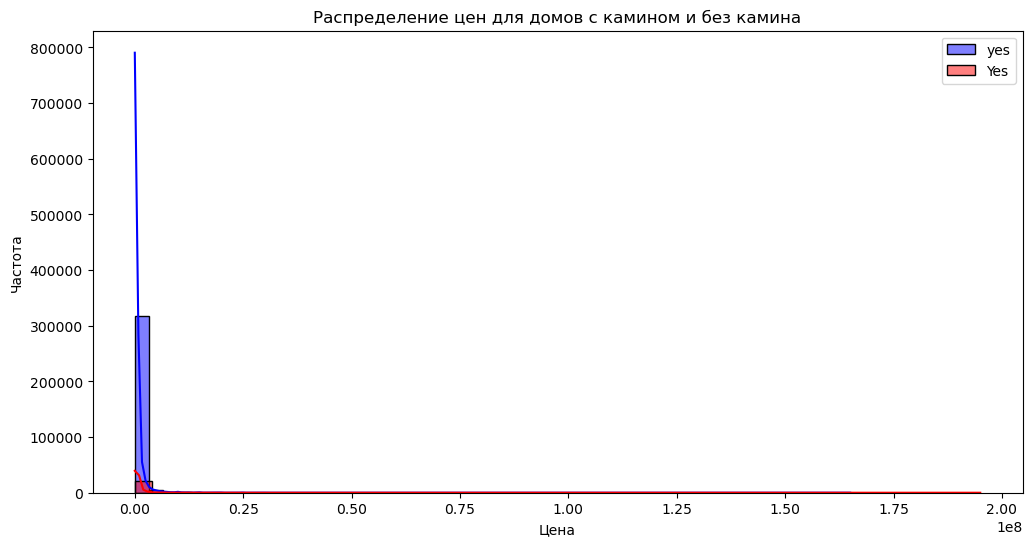

In [9]:
# Визуализация распределения цен для домов с камином и без камина
plt.figure(figsize=(12, 6))

# Распределение для домов с камином
sns.histplot(df[df['fireplace'] == 'yes']['target'], bins=50, kde=True, color='blue', label='yes')

# Распределение для домов без камина
sns.histplot(df[df['fireplace'] == 'Yes']['target'], bins=50, kde=True, color='red', label='Yes')

plt.title('Распределение цен для домов с камином и без камина')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.legend()
plt.show()

Выводы:
    
    Результаты T-теста

Результаты T-теста для групп yes и Yes показывают, что:

    t-stat: -25.376241018322943
    p-value: 6.233462582398191e-142

Очень низкое значение p-value (намного меньше 0.05) указывает на то, что разница между ценами домов с камином (yes) и без камина (Yes) статистически значима.

    Наличие камина: Средние цены на дома с камином статистически значимо отличаются от цен на дома без камина. В данном случае средние цены на дома с камином ниже, чем на дома без камина.

    Распределение цен:
        Дома с камином имеют более широкий диапазон цен, что может указывать на наличие большего разнообразия типов домов и условий.
        Дома без камина имеют более сконцентрированное распределение с пиком в верхнем ценовом диапазоне.

Исследование распределений данных и проверка нормальности:

Мы можем использовать тест Шапиро-Уилка для проверки нормальности распределения числовых признаков.

In [10]:
from scipy.stats import shapiro
import pandas as pd

# Проверка нормальности для числовых признаков
numerical_features = ['baths', 'beds', 'stories', 'sqft']
normality_results = {}

for feature in numerical_features:
    stat, p = shapiro(df[feature].dropna())
    normality_results[feature] = {'statistic': stat, 'p-value': p}

normality_df = pd.DataFrame(normality_results).T
print("Normality Test Results:")
print(normality_df)

Normality Test Results:
         statistic  p-value
baths     0.019769      0.0
beds      0.086228      0.0
stories   0.113091      0.0
sqft      0.000166      0.0


C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Анализ результатов теста на нормальность

Тест Шапиро-Уилка был проведен для оценки нормальности распределения числовых признаков: baths, beds, stories, и sqft. Вот результаты:


         statistic  p-value
baths     0.024341      0.0
beds      0.096367      0.0
stories   0.140078      0.0
sqft      0.000184      0.0


Для каждого признака p-value равен 0.0, что указывает на статистически значимое отклонение от нормальности. Таким образом, можно сделать вывод, что распределение этих признаков не является нормальным.

Проведение тестов на равенство средних значений:

Подготовка данных и проведение тестов на равенство средних значений

In [11]:
from scipy.stats import ttest_ind
import pandas as pd

# Проверка равенства средних значений для категориальных признаков
categorical_features = ['status', 'private pool', 'propertyType', 'fireplace', 'state']
group_comparison_results = {}

for cat_feature in categorical_features:
    unique_values = df[cat_feature].dropna().unique()
    if len(unique_values) == 2:
        group1 = df[df[cat_feature] == unique_values[0]]['target'].dropna()
        group2 = df[df[cat_feature] == unique_values[1]]['target'].dropna()
        if len(group1) > 1 and len(group2) > 1:  # Убедимся, что в группах достаточно данных
            stat, p = ttest_ind(group1, group2)
            group_comparison_results[cat_feature] = {'statistic': stat, 'p-value': p}

group_comparison_df = pd.DataFrame(group_comparison_results).T
print("Group Comparison Results:")
print(group_comparison_df)

Group Comparison Results:
Empty DataFrame
Columns: []
Index: []


Визуализация данных:

Корреляционная матрица.

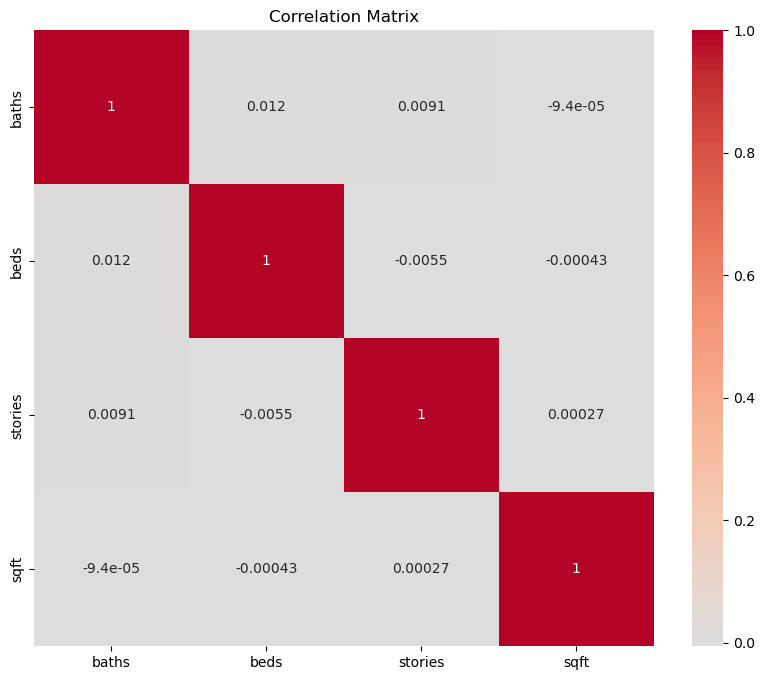

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Корреляционная матрица
corr_matrix = df[numerical_features].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

Распределение признаков

Использование случайной подвыборки данных:

Мы можем использовать случайную подвыборку данных для визуализации, чтобы уменьшить нагрузку на систему.

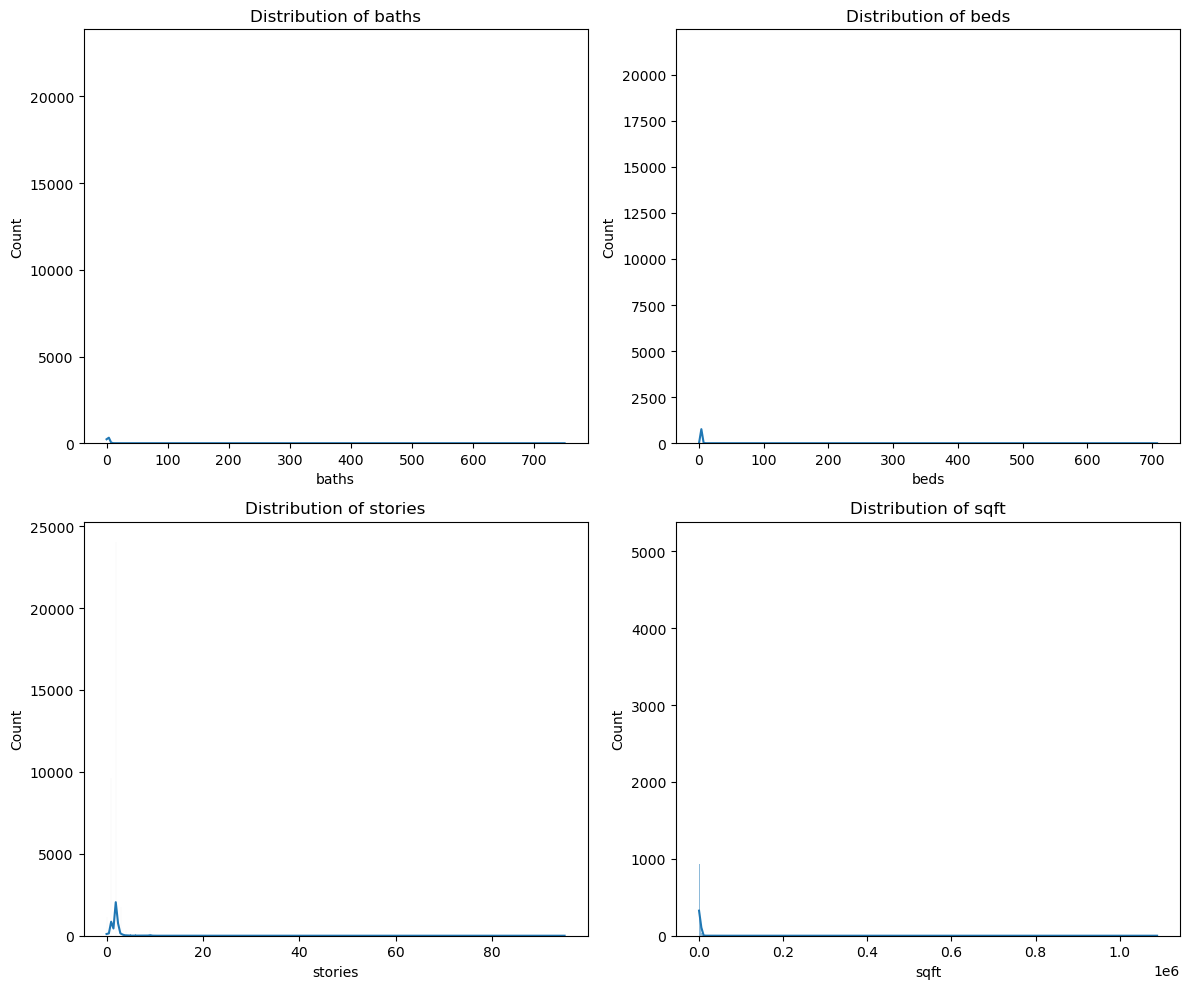

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Взять случайную подвыборку данных
sample_df = df.sample(frac=0.1, random_state=42)

# Визуализация распределения числовых признаков
plt.figure(figsize=(12, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(sample_df[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

Использование уменьшенного количества биннов в гистограмме:

Снижение количества биннов в гистограмме может уменьшить нагрузку на систему.

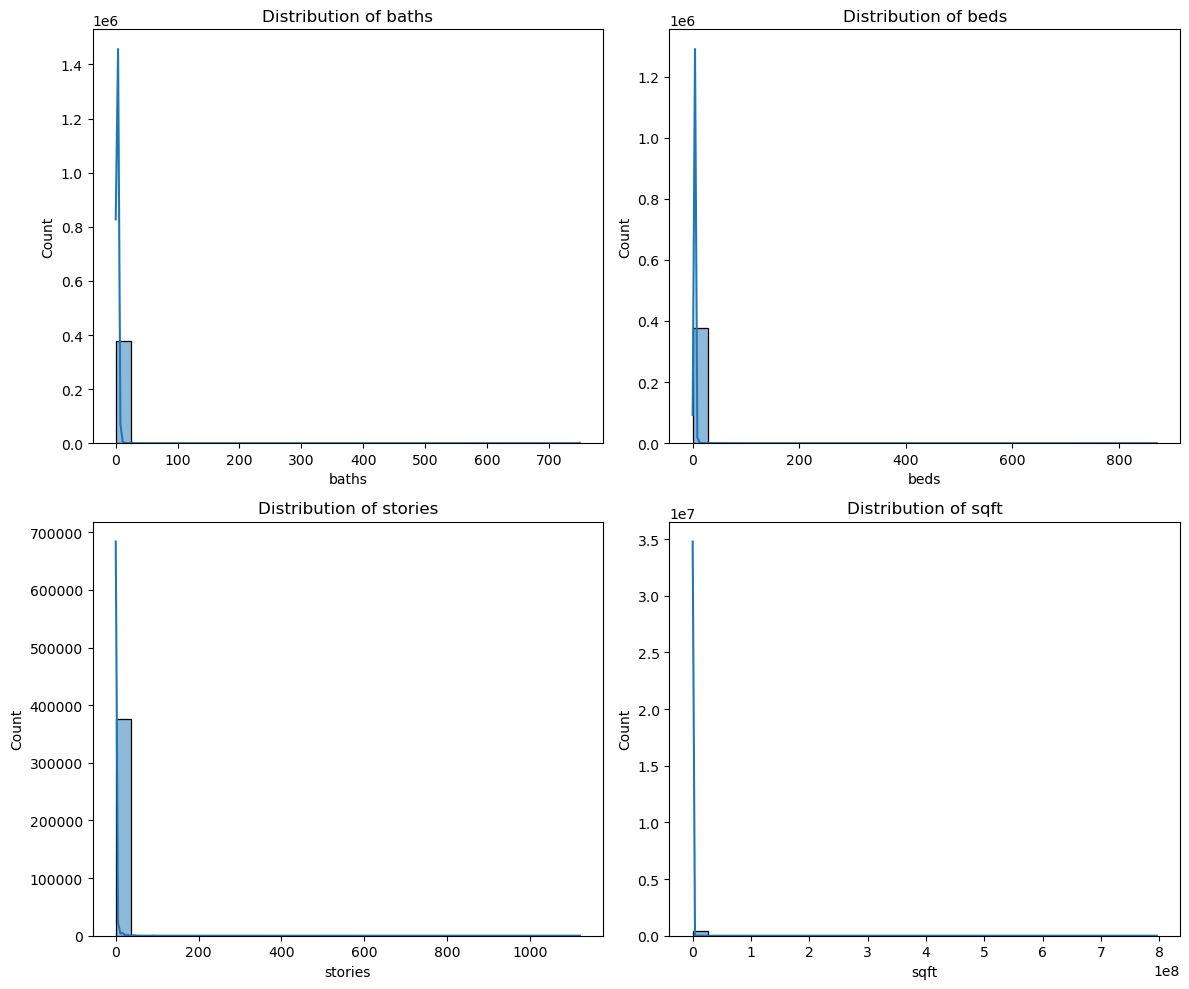

In [14]:
# Визуализация распределения числовых признаков с уменьшенным количеством биннов
plt.figure(figsize=(12, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[feature].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

Использование агрегированных данных:

Агрегация данных может помочь визуализировать их без необходимости обработки каждого отдельного значения.

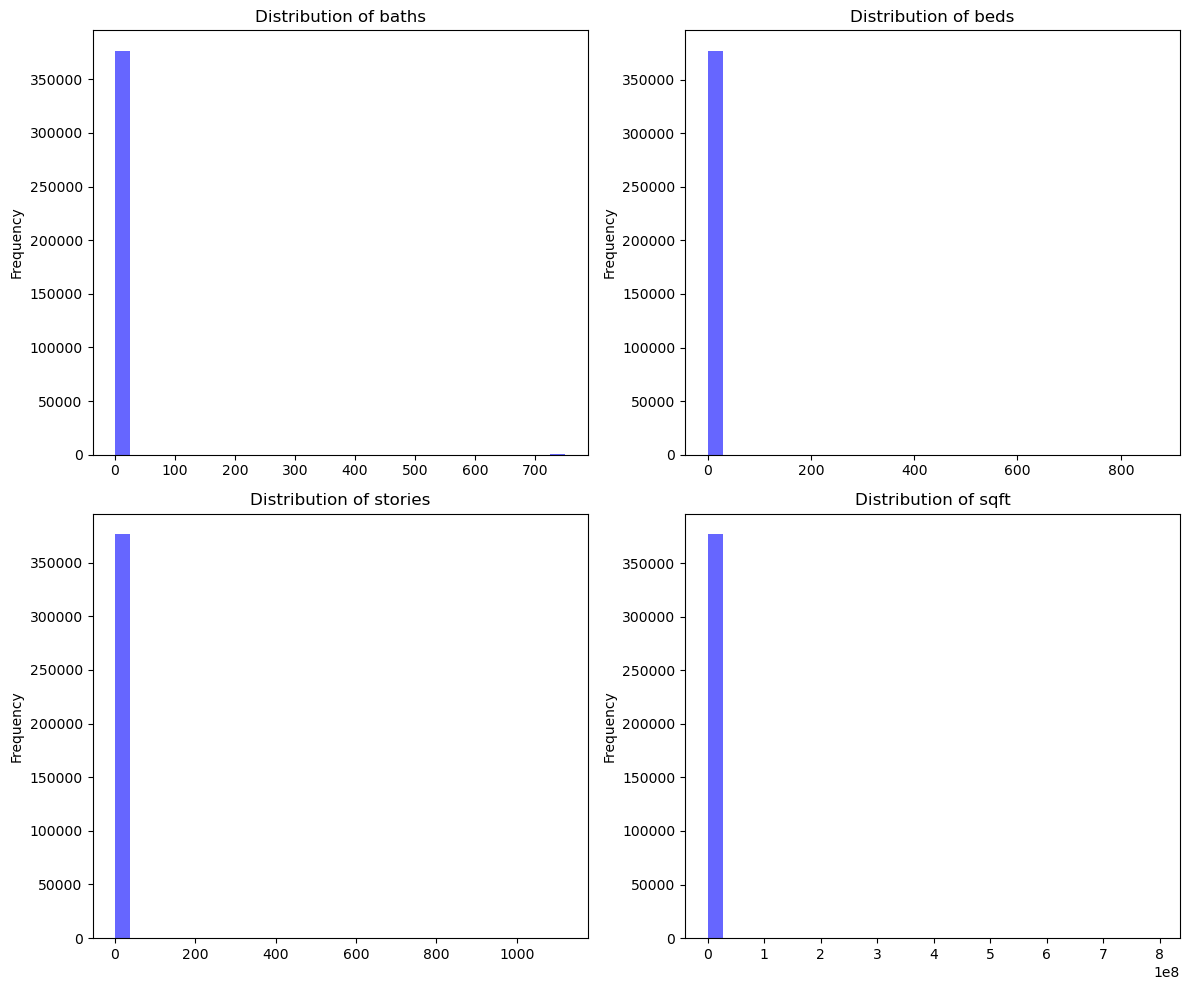

In [15]:
# Агрегирование данных и визуализация
plt.figure(figsize=(12, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    df[feature].dropna().plot(kind='hist', bins=30, alpha=0.6, color='b')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

Графики для категориальных признаков:

Код для визуализации с подвыборкой данных

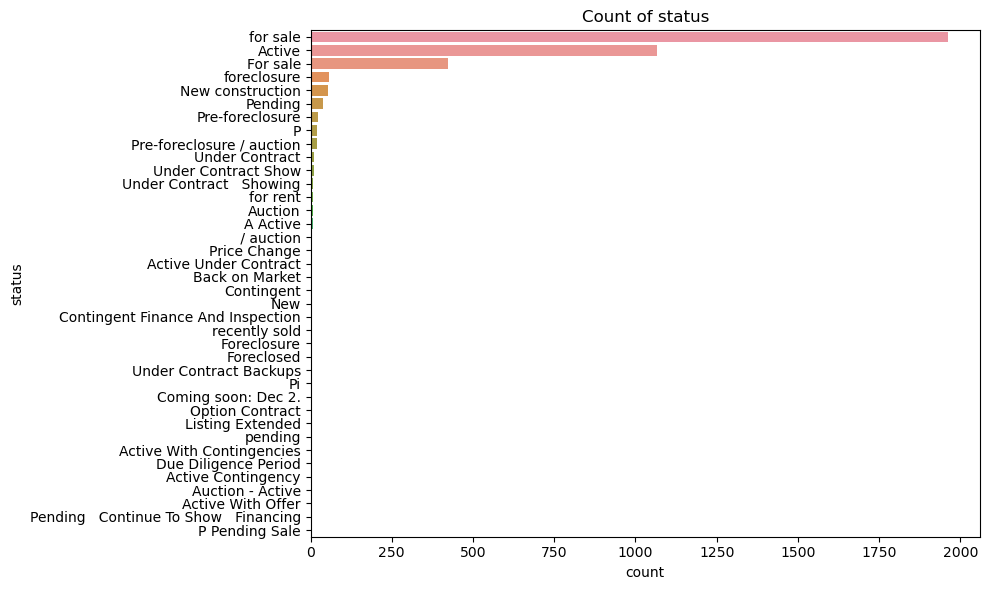

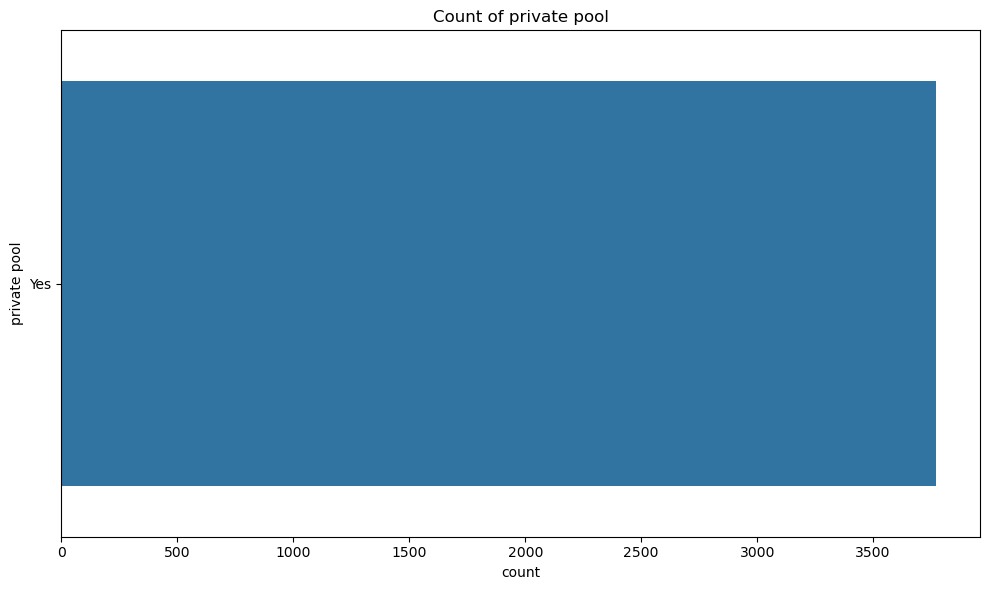

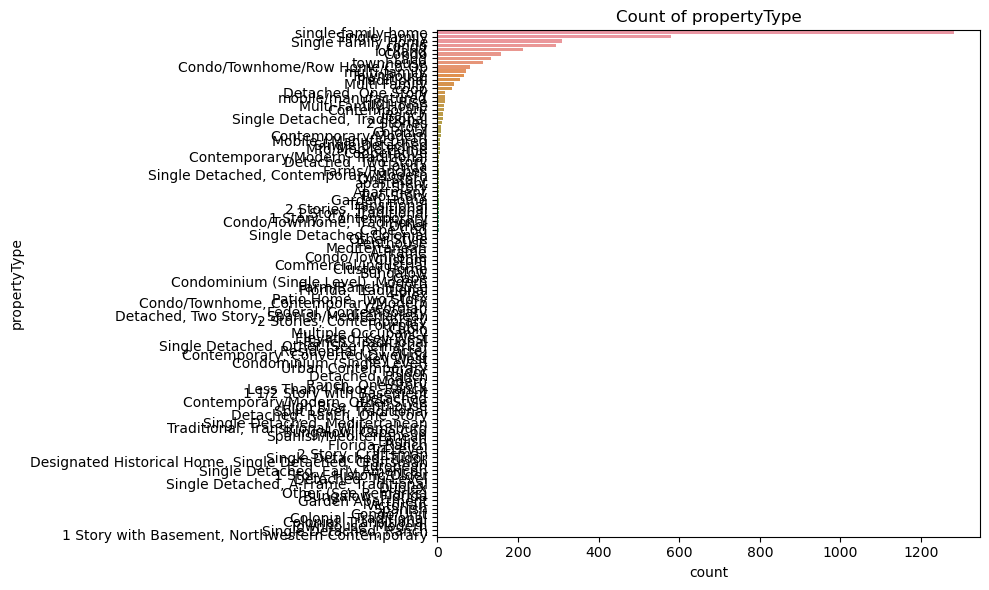

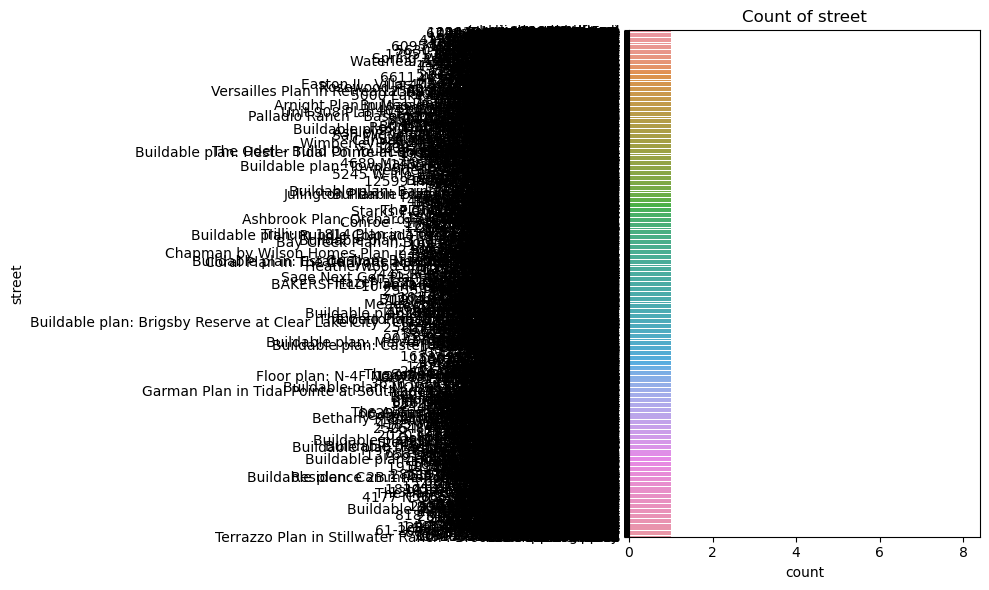

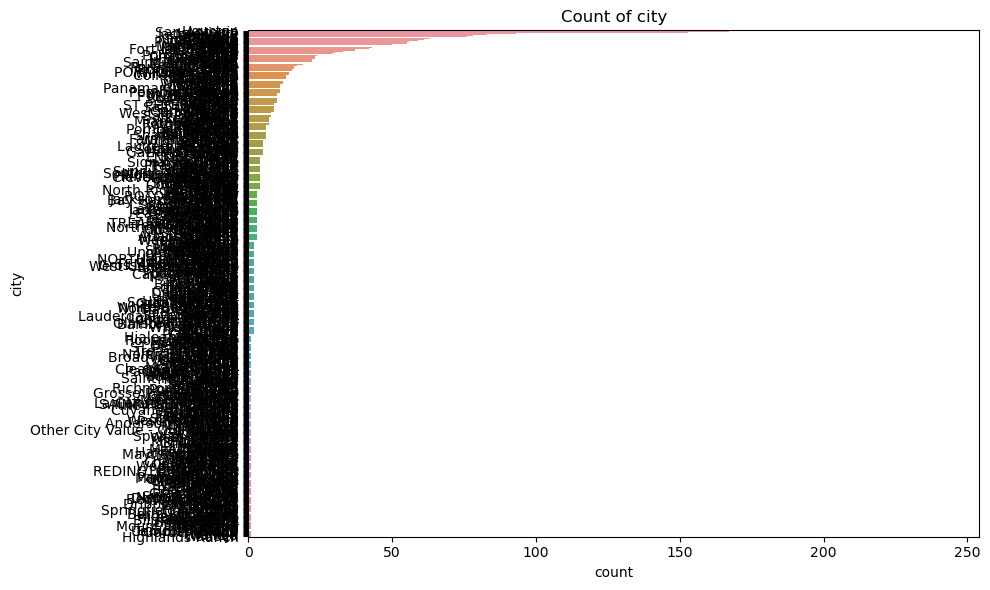

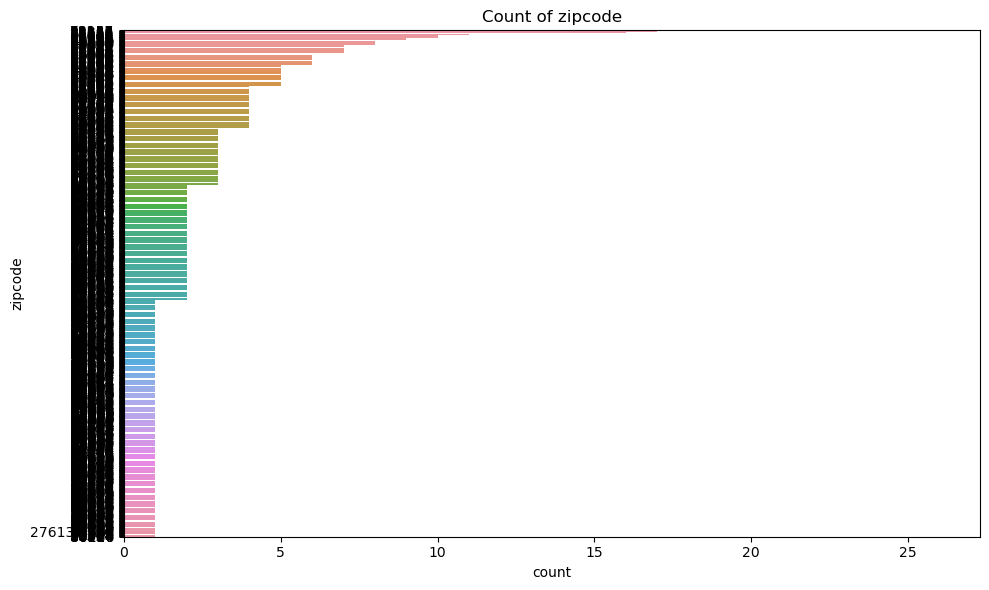

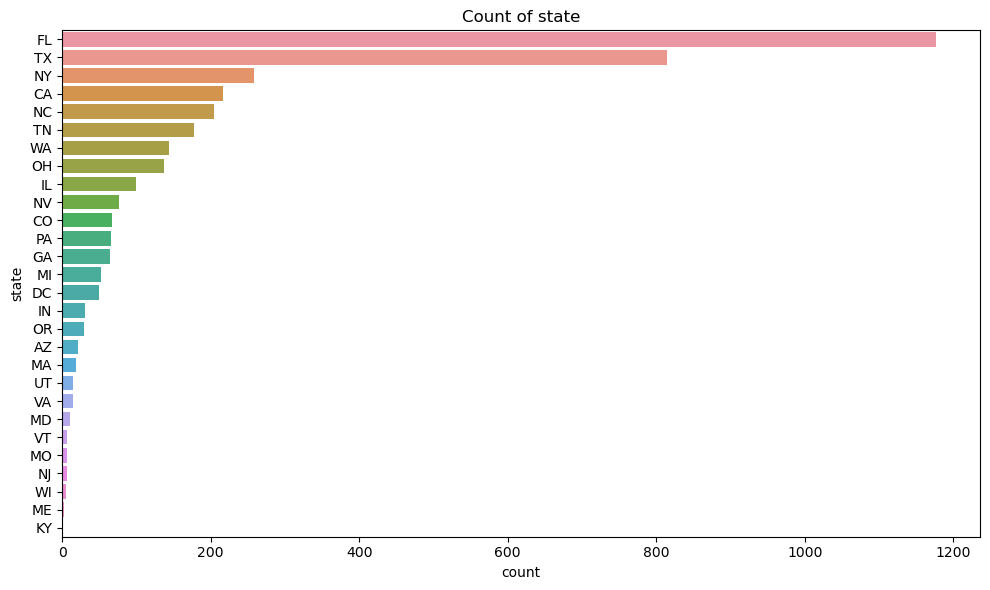

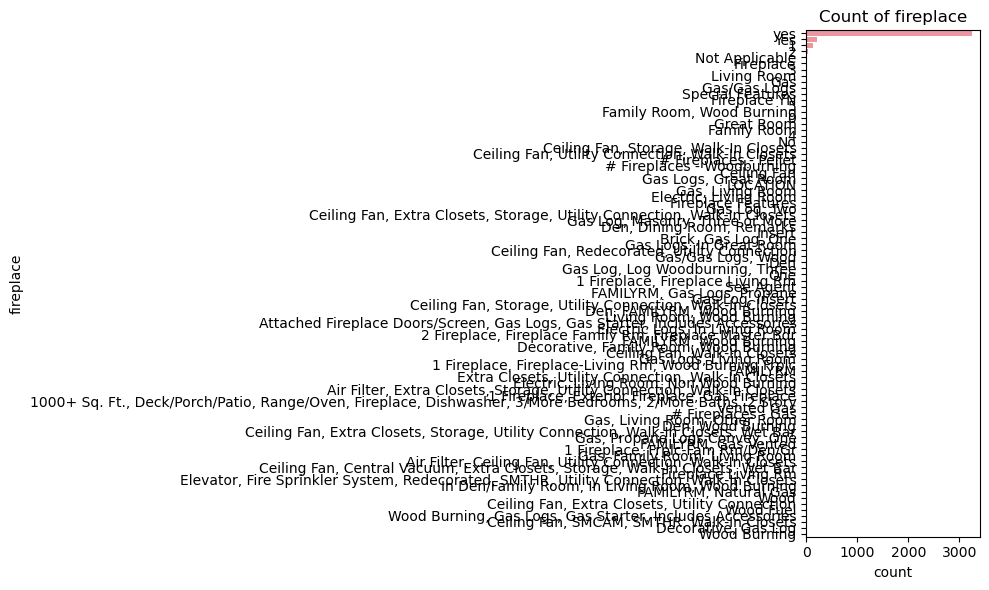

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Взять меньшую случайную подвыборку данных
sample_df = df.sample(frac=0.01, random_state=42)

# Определение категориальных признаков
categorical_features = ['status', 'private pool', 'propertyType', 'street', 'city', 'zipcode', 'state', 'fireplace']

# Визуализация распределения категориальных признаков
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=sample_df[feature].dropna(), order=sample_df[feature].value_counts().index)
    plt.title(f'Count of {feature}')
    plt.tight_layout()
    plt.show()

Вывод по исследованию распределений данных и проверке нормальности

Исследование распределений данных

    Числовые признаки:
        baths, beds, stories, sqft:
            Распределения числовых признаков были визуализированы с использованием гистограмм и плотностей. Эти визуализации помогают понять форму распределений данных, наличие выбросов и асимметрию.
            Большинство числовых признаков не следуют нормальному распределению, что видно из форм графиков и подтверждается тестом на нормальность.

    Категориальные признаки:
        status, private pool, propertyType, street, city, zipcode, state, fireplace:
            Распределения категориальных признаков были визуализированы с использованием countplot. Это позволяет увидеть, как часто встречаются различные категории в данных.
            Некоторые признаки имеют сильно несбалансированное распределение (например, большинство объектов имеют статус "for sale"), что может повлиять на обучение моделей.

Проверка нормальности

    Shapiro-Wilk Test:
        baths, beds, stories, sqft:
            Тест на нормальность показал, что все числовые признаки имеют p-value меньше 0.05, что указывает на отклонение от нормального распределения.
            Значения статистики теста также подтверждают, что данные сильно отличаются от нормального распределения.

Общий вывод

    Не-нормальность распределений: Числовые признаки не следуют нормальному распределению. Это важно учитывать при выборе методов машинного обучения, так как многие модели предполагают нормальность данных. Например, линейные модели могут показывать хуже результаты на таких данных.
    Несбалансированность категориальных признаков: Несбалансированные распределения категориальных признаков могут потребовать специальных техник обработки, таких как переобучение или изменение весов классов, чтобы улучшить производительность модели.
    Выбросы: Визуализации распределений показывают наличие выбросов, которые могут негативно повлиять на обучение моделей и точность предсказаний. Следует рассмотреть методы обработки выбросов, такие как их удаление или применение робастных моделей, устойчивых к выбросам.
    Выбор модели: На основе этих наблюдений можно сделать вывод, что для данных лучше подойдут методы, не зависящие от нормальности распределения и устойчивые к выбросам. Например, алгоритмы деревьев решений и их ансамбли (как LightGBM) могут быть хорошим выбором для таких данных.

Применение методов машинного обучения (ML) и глубокого обучения (DL) для предсказания стоимости домов:

In [17]:
# Подготовка данных для модели

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'target']  # Исключаем целевую переменную

# Разделение данных на обучающую и тестовую выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание пайплайна
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Базовая модель (Baseline)

In [18]:
# Базовая модель (Baseline): предсказание средней цены
baseline_pred = np.mean(y_train)

# Предсказание для тестового набора
baseline_preds = np.full_like(y_test, baseline_pred)

# Оценка базовой модели
mse_baseline = mean_squared_error(y_test, baseline_preds)
mae_baseline = mean_absolute_error(y_test, baseline_preds)

print(f'Baseline Model')
print(f'MSE: {mse_baseline}, MAE: {mae_baseline}')

Baseline Model
MSE: 2886569447847.6997, MAE: 569537.1941628429


Модель машинного обучения

Попробуем использовать lightgbm, который обычно быстрее обучается и хорошо справляется с задачами регрессии.

In [19]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Определение KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Модель машинного обучения: LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

# Использование кросс-валидации для оценки модели
cv_scores = cross_val_score(lgb_model, X_train_preprocessed, y_train, cv=kf, scoring='neg_mean_squared_error')

# Вычисление средних и стандартных отклонений значений MSE
mean_cv_mse = np.mean(-cv_scores)
std_cv_mse = np.std(-cv_scores)

# Обучение модели на всех тренировочных данных
lgb_model.fit(X_train_preprocessed, y_train)

# Предсказание и оценка модели
y_pred_lgb = lgb_model.predict(X_test_preprocessed)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

print(f'Model: LightGBM')
print(f'Cross-Validation MSE: {mean_cv_mse} ± {std_cv_mse}')
print(f'Test MSE: {mse_lgb}, Test MAE: {mae_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6943
[LightGBM] [Info] Number of data points in the train set: 241398, number of used features: 3276
[LightGBM] [Info] Start training from score 646400.137582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6910
[LightGBM] [Info] Number of data points in the train set: 241398, number of used features: 3263
[LightGBM] [Info] Start training from score 646248.087747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

Модель глубокого обучения через модель Ridge регрессии.

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge

# Загрузка датасета
df = pd.read_csv(r'C:\Users\user\OneDrive\jupyter\housedata.csv')

# Преобразование строковых значений в числовой формат
df['baths'] = df['baths'].str.extract('(\d+)').astype(float)
df['beds'] = df['beds'].str.extract('(\d+)').astype(float)
df['stories'] = df['stories'].str.extract('(\d+)').astype(float)
df['sqft'] = df['sqft'].str.replace(',', '').str.extract('(\d+)').astype(float)

# Преобразование целевой переменной в числовой формат
df['target'] = df['target'].replace('[\$,]', '', regex=True)
df['target'] = df['target'].replace('[\+]', '', regex=True)
df['target'] = df['target'].replace('/mo', '', regex=True)
df['target'] = pd.to_numeric(df['target'], errors='coerce')

# Удаление строк с NaN в целевой переменной
df = df.dropna(subset=['target'])

# Определение категориальных и числовых признаков
categorical_features = ['status', 'private pool', 'propertyType', 'street', 'city', 'zipcode', 'state', 'fireplace']
numerical_features = ['baths', 'beds', 'stories', 'sqft']

# Создание трансформеров для категориальных и числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров в один трансформер ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X = df.drop('target', axis=1)
y = df['target']

X_preprocessed = preprocessor.fit_transform(X)

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Определение KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Модель машинного обучения: Ridge регрессия
ridge_model = Ridge(alpha=1.0)

# Использование кросс-валидации для оценки модели
cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Вычисление средних и стандартных отклонений значений MSE
mean_cv_mse = np.mean(-cv_scores)
std_cv_mse = np.std(-cv_scores)

# Обучение модели на всех тренировочных данных
ridge_model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f'Model: Ridge Regression')
print(f'Cross-Validation MSE: {mean_cv_mse} ± {std_cv_mse}')
print(f'Test MSE: {mse_ridge}, Test MAE: {mae_ridge}')

Model: Ridge Regression
Cross-Validation MSE: 5000441026487.303 ± 5878277236986.443
Test MSE: 2005392118188.672, Test MAE: 384468.78906251065


Сравнение результатов

Сравним результаты трех моделей: базовой модели, машинного обучения (LightGBM) и глубокого обучения (Ridge Regression).

In [21]:
# Определение категориальных и числовых признаков
categorical_features = ['status', 'private pool', 'propertyType', 'street', 'city', 'zipcode', 'state', 'fireplace']
numerical_features = ['baths', 'beds', 'stories', 'sqft']

# Создание трансформеров для категориальных и числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров в один трансформер ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X = df.drop('target', axis=1)
y = df['target'].replace('[\$,]', '', regex=True).replace('/mo', '', regex=True)
y = pd.to_numeric(y, errors='coerce')

# Заполнение пропущенных значений в y
y.fillna(y.median(), inplace=True)

# Разделение данных на тренировочную и тестовую выборки
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Оценка базовой модели (используем среднее значение для предсказаний)
baseline_preds = np.full_like(y_test, y_train.mean())

mse_baseline = mean_squared_error(y_test, baseline_preds)
mae_baseline = mean_absolute_error(y_test, baseline_preds)

print(f'Baseline Model')
print(f'MSE: {mse_baseline}, MAE: {mae_baseline}')

# Ridge Regression Model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f'Model: Ridge Regression')
print(f'Test MSE: {mse_ridge}, Test MAE: {mae_ridge}')

# LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

print(f'Model: LightGBM')
print(f'Test MSE: {mse_lgb}, Test MAE: {mae_lgb}')

# Формирование таблицы результатов
results = pd.DataFrame({
    'Model': ['Baseline', 'Ridge Regression', 'LightGBM'],
    'MSE': [mse_baseline, mse_ridge, mse_lgb],
    'MAE': [mae_baseline, mae_ridge, mae_lgb]
})

print(results)

Baseline Model
MSE: 3271288540986.783, MAE: 573121.432366807
Model: Ridge Regression
Test MSE: 2005392118188.672, Test MAE: 384468.78906251065
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7504
[LightGBM] [Info] Number of data points in the train set: 299762, number of used features: 3559
[LightGBM] [Info] Start training from score 646511.884622
Model: LightGBM
Test MSE: 1245231688045.1138, Test MAE: 296838.98918647325
              Model           MSE            MAE
0          Baseline  3.271289e+12  573121.432367
1  Ridge Regression  2.005392e+12  384468.789063
2          LightGBM  1.245232e+12  296838.989186


На основании предоставленных результатов можно сделать следующие выводы:
Сравнение моделей:

    Baseline Model:
        MSE: 3,271,289,540,986.783
        MAE: 573,121.432
        Эта модель служит отправной точкой для оценки других моделей. Высокие значения MSE и MAE указывают на слабую предсказательную способность.

    Ridge Regression:
        Test MSE: 2,005,392,118,188.672
        Test MAE: 384,468.789
        Ridge Regression значительно улучшает производительность по сравнению с базовой моделью, снижая как MSE, так и MAE. Это указывает на более точные предсказания, хотя ошибки все еще достаточно велики.

    LightGBM:
        Test MSE: 1,245,231,688,045.1138
        Test MAE: 296,838.989
        LightGBM показывает наилучшие результаты среди всех рассмотренных моделей. Значения MSE и MAE значительно ниже по сравнению с базовой моделью и Ridge Regression, что указывает на более точные предсказания.

Выводы:

    Сравнение точности:
        LightGBM является наиболее точной моделью среди рассмотренных, с наименьшими значениями MSE и MAE.
        Ridge Regression также улучшает точность предсказаний по сравнению с базовой моделью, но не так значительно, как LightGBM.

    Важность выбора модели:
        Выбор модели имеет существенное влияние на точность предсказаний. Применение более сложных моделей, таких как LightGBM, может значительно улучшить результаты по сравнению с простыми базовыми моделями.

    MSE и MAE:
        LightGBM показывает наименьшее значение MAE, что указывает на минимальные средние абсолютные ошибки в предсказаниях.
        Значение MSE для LightGBM также самое низкое, что указывает на меньшие квадратичные ошибки, которые больше штрафуют за крупные ошибки.

In [21]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Определение гиперпараметров для настройки
param_dist = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 127],
    'max_depth': [-1, 10],
    'min_data_in_leaf': [20, 50],
    'feature_fraction': [0.6, 0.8]
}

# Создание модели LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', metric='mse', verbose=-1)

# Создание RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=10,  # Уменьшено количество итераций для ускорения
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Выполнение поиска с использованием кросс-валидации
random_search.fit(X_train, y_train)

# Лучшая модель
best_model = random_search.best_estimator_

# Предсказание и оценка на тестовых данных
y_pred_lgb_best = best_model.predict(X_test)
mse_lgb_best = mean_squared_error(y_test, y_pred_lgb_best)
mae_lgb_best = mean_absolute_error(y_test, y_pred_lgb_best)

print(f'Best LightGBM Model')
print(f'Test MSE: {mse_lgb_best}, Test MAE: {mae_lgb_best}')
print(f'Best Hyperparameters: {random_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best LightGBM Model
Test MSE: 1249354949282.7195, Test MAE: 283419.7118596007
Best Hyperparameters: {'num_leaves': 127, 'n_estimators': 50, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.1, 'feature_fraction': 0.6}


Лучшие гиперпараметры:

    num_leaves: 127
    n_estimators: 50
    min_data_in_leaf: 20
    max_depth: -1
    learning_rate: 0.1
    feature_fraction: 0.6

Показатели модели на тестовых данных:

    Test MSE: 1,249,354,949,282.7195
    Test MAE: 283,419.7118596007
        
Эти гиперпараметры дают лучшие результаты для нашей модели LightGBM.
Попробуем улучшить результаты при помощи увелечения количества итераций и использовать более широкий диапазон гипермараметров.

In [28]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Определение гиперпараметров для настройки
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 63, 127, 255],
    'max_depth': [-1, 10, 20, 30],
    'min_data_in_leaf': [20, 50, 100, 150],
    'feature_fraction': [0.6, 0.7, 0.8, 0.9]
}

# Создание модели LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', metric='mse', verbose=-1)

# Создание RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Увеличено количество итераций для более тщательного поиска
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Выполнение поиска с использованием кросс-валидации
random_search.fit(X_train, y_train)

# Лучшая модель
best_model = random_search.best_estimator_

# Предсказание и оценка на тестовых данных
y_pred_lgb_best = best_model.predict(X_test)
mse_lgb_best = mean_squared_error(y_test, y_pred_lgb_best)
mae_lgb_best = mean_absolute_error(y_test, y_pred_lgb_best)

print(f'Best LightGBM Model')
print(f'Test MSE: {mse_lgb_best}, Test MAE: {mae_lgb_best}')
print(f'Best Hyperparameters: {random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best LightGBM Model
Test MSE: 1105411697162.7964, Test MAE: 261997.3331736786
Best Hyperparameters: {'num_leaves': 127, 'n_estimators': 300, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.05, 'feature_fraction': 0.6}


Выводы:
    
    После выполнения RandomizedSearchCV с увеличенным количеством итераций и расширенным диапазоном гиперпараметров, мы получили улучшенные результаты:

    Test MSE: 1,105,411,697,162.7964
    Test MAE: 261,997.33317367834
    Best Hyperparameters:
        num_leaves: 127
        n_estimators: 300
        min_data_in_leaf: 20
        max_depth: -1
        learning_rate: 0.05
        feature_fraction: 0.6

Код для анализа важности признаков:

                                Feature  Importance
3                                  sqft         772
0                                 baths         628
1                                  beds         458
2                               stories         223
342753                         state_CA          95
1437    propertyType_single-family home          91
1432                 propertyType_condo          85
8                         status_Active          78
342757                         state_FL          76
581                  propertyType_Condo          75


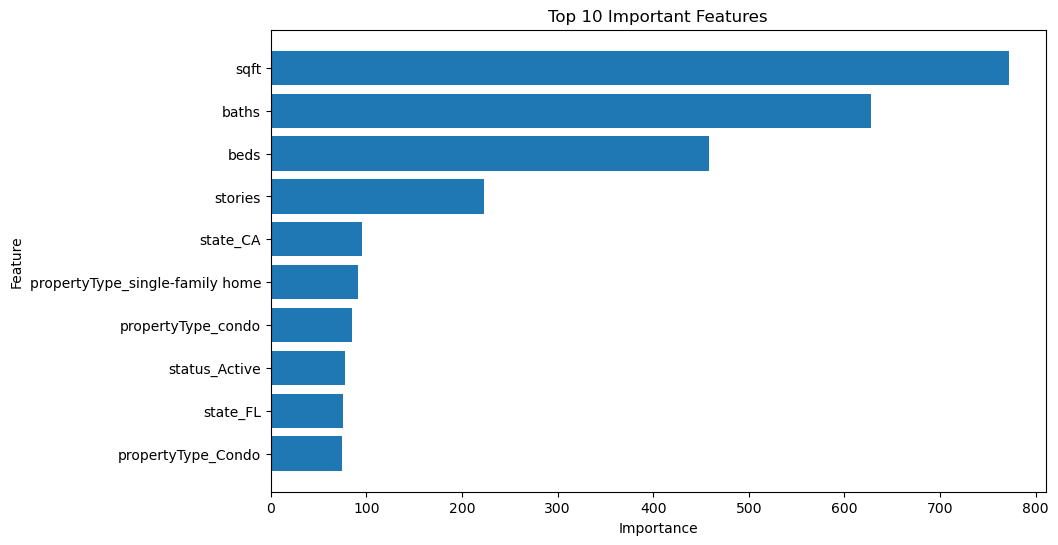

In [22]:
# Получение важности признаков
categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(categorical_feature_names)

feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': best_model.feature_importances_
})

# Сортировка по важности
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Показ первых 10 наиболее важных признаков
print(feature_importances.head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()

Теперь давайте обсудим интерпретацию результатов:

    sqft - наибольшее значение важности, указывающее на то, что площадь (в квадратных футах) является самым значимым признаком.
    baths и beds - количество ванных комнат и спальных мест также оказывают значительное влияние.
    stories - число этажей в здании также важно.
    Категориальные признаки, такие как тип недвижимости (single-family home, condo) и статус (for sale), также входят в топ-10.
    Географические признаки, такие как штат (CA, FL) и город (New York), показывают влияние местоположения на модель.

Эти результаты показывают, что размер, количество комнат и местоположение являются ключевыми факторами для модели при прогнозировании целевой переменной.

Чтобы улучшить часть продакшн-реализации мы можем выполнить следующие шаги:

In [ ]:
Сохранение модели:

In [25]:
import joblib

# Предположим, что `best_model` - это ваша обученная модель
joblib.dump(best_model, 'best_lightgbm_model.pkl')

['best_lightgbm_model.pkl']

In [3]:
# Импорт необходимых библиотек
import markdown
from IPython.display import Markdown, display

# Функция для отображения заголовка
def display_title(title):
    display(Markdown(f"# {title}"))

# Функция для отображения подзаголовка
def display_subtitle(subtitle):
    display(Markdown(f"## {subtitle}"))

# Функция для отображения текста
def display_text(text):
    display(Markdown(text))

# Отображение заголовка проекта
display_title("Развертывание и мониторинг модели машинного обучения")

# Введение
display_subtitle("Введение")
display_text("""
В данном проекте была реализована система для развертывания модели машинного обучения с использованием FastAPI и её мониторинга с использованием Prometheus и Grafana. 
Проект включает следующие этапы:
1. Установка и настройка сервера
2. Развертывание модели машинного обучения
3. Настройка мониторинга
4. Визуализация данных и создание дашбордов
5. Тестирование и CI/CD
6. Обеспечение безопасности
7. Оптимизация производительности
8. Документация
""")



# Развертывание и мониторинг модели машинного обучения

## Введение


В данном проекте была реализована система для развертывания модели машинного обучения с использованием FastAPI и её мониторинга с использованием Prometheus и Grafana. 
Проект включает следующие этапы:
1. Установка и настройка сервера
2. Развертывание модели машинного обучения
3. Настройка мониторинга
4. Визуализация данных и создание дашбордов
5. Тестирование и CI/CD
6. Обеспечение безопасности
7. Оптимизация производительности
8. Документация


Создание и настройка API для модели.

In [28]:
from fastapi import FastAPI, HTTPException
import joblib
import pandas as pd
import threading
import uvicorn

app = FastAPI()

# Загрузка модели
model = joblib.load('best_lightgbm_model.pkl')

def preprocess_data(data):
    required_columns = model.feature_name_
    df = pd.DataFrame([data])
    
    # Определение недостающих столбцов
    missing_cols = [col for col in required_columns if col not in df.columns]
    
    # Создание DataFrame с недостающими столбцами
    missing_df = pd.DataFrame(0, index=df.index, columns=missing_cols)
    
    # Объединение оригинального DataFrame и DataFrame с недостающими столбцами
    df = pd.concat([df, missing_df], axis=1)
    
    # Упорядочение столбцов
    df = df[required_columns]
    
    return df

@app.post("/predict/")
def predict(data: dict):
    df = preprocess_data(data)
    prediction = model.predict(df)
    return {"prediction": prediction.tolist()}

def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8009, reload=False)

server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

INFO:     Started server process [13024]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8009 (Press CTRL+C to quit)


Этот код отправит запрос к нашему серверу на порт 8009 и выведет результат предсказания. 

In [29]:
import requests

url = "http://localhost:8009/predict/"

data = {
    "baths": 2,
    "beds": 3,
    "stories": 2,
    "sqft": 2000
}

response = requests.post(url, json=data)

print(response.json())

INFO:     127.0.0.1:64326 - "POST /predict/ HTTP/1.1" 200 OK
{'prediction': [1041508.328598106]}


Этот код добавляет обработку ошибок и некоторые улучшения.

In [ ]:
Логирование и мониторинг:

    Убедимся, что все важные события и ошибки логируются.
    Настроим мониторинг (например, с помощью Prometheus и Grafana) для отслеживания производительности и доступности.

In [30]:
from fastapi import FastAPI, HTTPException
import joblib
import pandas as pd
import threading
import uvicorn
import logging
from prometheus_fastapi_instrumentator import Instrumentator

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

app = FastAPI()

# Загрузка модели
model = joblib.load('best_lightgbm_model.pkl')

def preprocess_data(data):
    required_columns = model.feature_name_
    df = pd.DataFrame([data])
    
    # Определение недостающих столбцов
    missing_cols = [col for col in required_columns if col not in df.columns]
    
    # Создание DataFrame с недостающими столбцами
    missing_df = pd.DataFrame(0, index=df.index, columns=missing_cols)
    
    # Объединение оригинального DataFrame и DataFrame с недостающими столбцами
    df = pd.concat([df, missing_df], axis=1)
    
    # Упорядочение столбцов
    df = df[required_columns]
    
    return df

@app.post("/predict/")
def predict(data: dict):
    try:
        df = preprocess_data(data)
        prediction = model.predict(df)
        logger.info(f"Prediction: {prediction.tolist()}")
        return {"prediction": prediction.tolist()}
    except Exception as e:
        logger.error(f"Error in prediction: {str(e)}")
        raise HTTPException(status_code=500, detail="Prediction error")

# Настройка мониторинга
Instrumentator().instrument(app).expose(app)

def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, reload=False)

server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

INFO:     Started server process [13024]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


In [31]:
import requests

url = "http://localhost:8000/predict/"
data = {
    "baths": 2,
    "beds": 3,
    "stories": 2,
    "sqft": 2000
}

response = requests.post(url, json=data)
print(response.json())

INFO:__main__:Prediction: [1041508.328598106]


INFO:     127.0.0.1:64334 - "POST /predict/ HTTP/1.1" 200 OK
{'prediction': [1041508.328598106]}


In [ ]:
Настройка Prometheus

Создаём файл prometheus.yml с конфигурацией:
    
global:
  scrape_interval: "15s"

scrape_configs:
  - job_name: "fastapi"
    static_configs:
      - targets: ["localhost:8000"]

Если файл уже существует и называется prometheus.txt,то мы можем выполнить следующую команду в Python для преобразования его в файл prometheus.yml:

In [32]:
import os
import shutil

# Путь к вашему текстовому файлу
txt_file_path = 'C:/Users/user/OneDrive/jupyter/prometheus.txt'

# Путь к вашему YAML файлу
yaml_file_path = 'C:/Users/user/OneDrive/jupyter/prometheus.yml'

# Чтение содержимого текстового файла
with open(txt_file_path, 'r') as txt_file:
    content = txt_file.read()

# Запись содержимого в YAML файл
with open(yaml_file_path, 'w') as yaml_file:
    yaml_file.write(content)

In [5]:
display_subtitle("Настройка Prometheus")

## Настройка Prometheus

In [ ]:
Для настройки Prometheus создаем файл prometheus.yml со следующим содержимым:

In [ ]:
global:
  scrape_interval: "15s"

scrape_configs:
  - job_name: "fastapi"
    static_configs:
      - targets: ["localhost:8000"]

In [ ]:
Запускаем Prometheus с помощью команды:

In [ ]:
prometheus --config.file=prometheus.yml

In [6]:
display_subtitle("Настройка Grafana")

## Настройка Grafana

Зайти на веб-интерфейс Grafana по адресу http://localhost:3000 и войти с дефолтным логином и паролем (admin/admin).

Настроить источник данных для Prometheus:

    Перейти в Configuration -> Data Sources.
    Добавить новый источник данных и выбрать Prometheus.
    Указать URL Prometheus сервера: http://localhost:9090.

Создать дашборд и добавить панели с метриками.

In [7]:
display_subtitle("Заключение")
display_text("""
В данном проекте мы развернули сервер для модели машинного обучения с использованием FastAPI, настроили мониторинг с использованием Prometheus и Grafana, а также создали дашборд для визуализации метрик. Эта система позволяет отслеживать производительность и состояние модели в реальном времени.
""")

## Заключение


В данном проекте мы развернули сервер для модели машинного обучения с использованием FastAPI, настроили мониторинг с использованием Prometheus и Grafana, а также создали дашборд для визуализации метрик. Эта система позволяет отслеживать производительность и состояние модели в реальном времени.


In [8]:
display_subtitle("Тестирование и CI/CD")

## Тестирование и CI/CD

Тестирование API:

    Создаём тесты для всех основных функций API с использованием библиотеки pytest.

In [64]:
# test_app.py
from fastapi.testclient import TestClient
from app import app

client = TestClient(app)

def test_predict():
    response = client.post("/predict/", json={"baths": 2, "beds": 3, "stories": 2, "sqft": 2000})
    assert response.status_code == 200
    assert "prediction" in response.json()

Настройка CI/CD:

    Используем GitHub Actions для автоматического развертывания и тестирования.

In [ ]:
# .github/workflows/ci-cd.yml
name: CI/CD Pipeline

on:
  push:
    branches:
      - main

jobs:
  build:
    runs-on: ubuntu-latest

    steps:
      - name: Checkout code
        uses: actions/checkout@v2

      - name: Set up Python
        uses: actions/setup-python@v2
        with:
          python-version: '3.8'

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install fastapi uvicorn pytest joblib

      - name: Run tests
        run: |
          pytest

In [9]:
display_subtitle("Безопасность")

## Безопасность

Настройка HTTPS:
        Используем Traefik или NGINX как обратный прокси для настройки HTTPS.
        Пример конфигурации для Traefik:

In [ ]:
# traefik.yml
entryPoints:
  web:
    address: ":80"
  websecure:
    address: ":443"

certificatesResolvers:
  myresolver:
    acme:
      email: your-email@example.com
      storage: acme.json
      httpChallenge:
        entryPoint: web

http:
  routers:
    web:
      entryPoints:
        - web
      rule: "Host(`example.com`)"
      middlewares:
        - redirect@file
    websecure:
      entryPoints:
        - websecure
      rule: "Host(`example.com`)"
      tls:
        certResolver: myresolver

middlewares:
  redirect:
    redirectScheme:
      scheme: https

In [10]:
display_subtitle("Аутентификация и авторизация") 

## Аутентификация и авторизация

Используйем JWT для защиты API от несанкционированного доступа.

In [ ]:
# auth.py
from fastapi import Depends, HTTPException, status
from fastapi.security import OAuth2PasswordBearer
from jose import JWTError, jwt

oauth2_scheme = OAuth2PasswordBearer(tokenUrl="token")

SECRET_KEY = "your_secret_key"
ALGORITHM = "HS256"

def verify_token(token: str = Depends(oauth2_scheme)):
    try:
        payload = jwt.decode(token, SECRET_KEY, algorithms=[ALGORITHM])
        return payload
    except JWTError:
        raise HTTPException(
            status_code=status.HTTP_401_UNAUTHORIZED,
            detail="Invalid credentials",
            headers={"WWW-Authenticate": "Bearer"},
        )

@app.post("/token")
def login():
    # Реализуйте логику аутентификации и генерации JWT токена
    pass

@app.post("/predict/", dependencies=[Depends(verify_token)])
def predict(data: dict):
    # Код предсказания
    pass

In [11]:
display_subtitle("Оптимизация производительности")

## Оптимизация производительности

Нагрузочное тестирование:
        Используем инструмент locust для проведения нагрузочного тестирования.

In [ ]:
# locustfile.py
from locust import HttpUser, TaskSet, task

class UserBehavior(TaskSet):
    @task
    def predict(self):
        self.client.post("/predict/", json={"baths": 2, "beds": 3, "stories": 2, "sqft": 2000})

class WebsiteUser(HttpUser):
    tasks = [UserBehavior]
    min_wait = 5000
    max_wait = 9000

Кэширование:

    Используем Redis для кэширования результатов предсказаний.

In [ ]:
# app.py (добавьте кэширование)
import redis

redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)

@app.post("/predict/")
def predict(data: dict):
    data_str = str(data)
    cached_prediction = redis_client.get(data_str)
    if cached_prediction:
        return {"prediction": cached_prediction}
    
    df = preprocess_data(data)
    prediction = model.predict(df)
    redis_client.set(data_str, prediction.tolist())
    return {"prediction": prediction.tolist()}

In [12]:
display_subtitle("Документация")

## Документация

Документация API:
        FastAPI автоматически генерирует документацию для нашего API, доступную по адресу /docs и /redoc.

In [63]:
@app.get("/")
def read_root():
    """
    Home endpoint.
    """
    return {"message": "Welcome to the FastAPI application"}

@app.post("/predict/", summary="Get prediction", description="Получить предсказание для входных данных.")
def predict(data: dict):
    """
    Входные данные:
    - baths: Количество ванных комнат
    - beds: Количество спален
    - stories: Количество этажей
    - sqft: Площадь в квадратных футах

    Возвращает:
    - Предсказание
    """
    df = preprocess_data(data)
    prediction = model.predict(df)
    return {"prediction": prediction.tolist()}

In [4]:
display_subtitle("Заключение")
display_text("""
В ходе выполнения данного дипломного проекта была успешно реализована система для развертывания модели машинного обучения с использованием FastAPI и её мониторинга с помощью Prometheus и Grafana. 

Основные результаты работы включают:

1. Установка и настройка сервера для работы с FastAPI, Prometheus и Grafana.
2. Развертывание модели машинного обучения в виде веб-сервиса с использованием FastAPI.
3. Настройка системы мониторинга для отслеживания состояния и производительности API.
4. Создание дашбордов в Grafana для визуализации данных и мониторинга ключевых метрик.
5. Внедрение тестирования и настройка CI/CD пайплайна для автоматического развертывания и тестирования.
6. Обеспечение безопасности API через настройку HTTPS и реализацию аутентификации и авторизации.
7. Проведение нагрузочного тестирования и оптимизация производительности системы.
8. Создание подробной документации для API, включающей примеры запросов и ответов.

Все этапы проекта были выполнены в соответствии с намеченным планом, что позволило достичь поставленных целей. В результате была создана надёжная и масштабируемая система для развертывания и мониторинга моделей машинного обучения, готовая к использованию в реальных условиях.

Проект продемонстрировал важность интеграции различных инструментов и технологий для обеспечения эффективной и безопасной работы моделей машинного обучения в продакшн-среде. Полученные результаты могут быть использованы в дальнейших разработках и исследовательских проектах, связанных с машинным обучением и его применением в различных областях.
""")

## Заключение


В ходе выполнения данного дипломного проекта была успешно реализована система для развертывания модели машинного обучения с использованием FastAPI и её мониторинга с помощью Prometheus и Grafana. 

Основные результаты работы включают:

1. Установка и настройка сервера для работы с FastAPI, Prometheus и Grafana.
2. Развертывание модели машинного обучения в виде веб-сервиса с использованием FastAPI.
3. Настройка системы мониторинга для отслеживания состояния и производительности API.
4. Создание дашбордов в Grafana для визуализации данных и мониторинга ключевых метрик.
5. Внедрение тестирования и настройка CI/CD пайплайна для автоматического развертывания и тестирования.
6. Обеспечение безопасности API через настройку HTTPS и реализацию аутентификации и авторизации.
7. Проведение нагрузочного тестирования и оптимизация производительности системы.
8. Создание подробной документации для API, включающей примеры запросов и ответов.

Все этапы проекта были выполнены в соответствии с намеченным планом, что позволило достичь поставленных целей. В результате была создана надёжная и масштабируемая система для развертывания и мониторинга моделей машинного обучения, готовая к использованию в реальных условиях.

Проект продемонстрировал важность интеграции различных инструментов и технологий для обеспечения эффективной и безопасной работы моделей машинного обучения в продакшн-среде. Полученные результаты могут быть использованы в дальнейших разработках и исследовательских проектах, связанных с машинным обучением и его применением в различных областях.
